/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Epoch 1/40 | Train Loss: 1.5903 | Val Acc: 0.4511
✅ Model saved.
Epoch 2/40 | Train Loss: 1.2768 | Val Acc: 0.4511
Epoch 3/40 | Train Loss: 0.9605 | Val Acc: 0.5714
✅ Model saved.
Epoch 4/40 | Train Loss: 0.7172 | Val Acc: 0.6165
✅ Model saved.
Epoch 5/40 | Train Loss: 0.5281 | Val Acc: 0.6767
✅ Model saved.
Epoch 6/40 | Train Loss: 0.4652 | Val Acc: 0.7368
✅ Model saved.
Epoch 7/40 | Train Loss: 0.4435 | Val Acc: 0.7368
Epoch 8/40 | Train Loss: 0.4367 | Val Acc: 0.7218
Epoch 9/40 | Train Loss: 0.4332 | Val Acc: 0.7293
Epoch 10/40 | Train Loss: 0.4328 | Val Acc: 0.7218
Epoch 11/40 | Train Loss: 0.4320 | Val Acc: 0.7218
Epoch 12/40 | Train Loss: 0.4335 | Val Acc: 0.7218
Epoch 13/40 | Train Loss: 0.4346 | Val Acc: 0.7068
⏹ Early stopping triggered.
              precision    recall  f1-score   support

     LEVEL_2       0.92      0.73      0.81        15
     LEVEL_3       0.73      0.67      0.70        12
     LEVEL_4       0.30      0.43      0.35         7
     LEVEL_5       0.59   

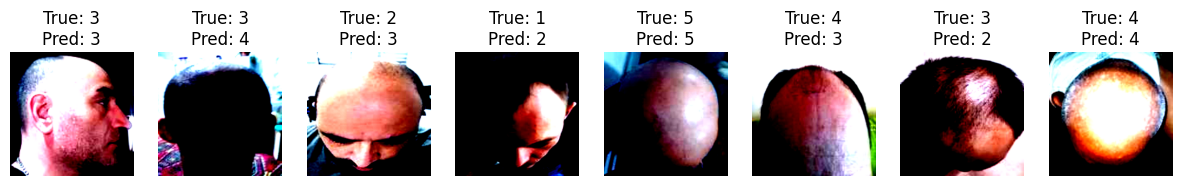

In [6]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix

# ======================
# Paths & Hyperparameters
# ======================
TRAIN_CSV = "/kaggle/input/hairfall/hair-loss.v2i.multiclass/train/_classes.csv"
TRAIN_IMG_DIR = "/kaggle/input/hairfall/hair-loss.v2i.multiclass/train/"
VALID_CSV = "/kaggle/input/hairfall/hair-loss.v2i.multiclass/valid/_classes.csv"
VALID_IMG_DIR = "/kaggle/input/hairfall/hair-loss.v2i.multiclass/valid/"
TEST_CSV  = "/kaggle/input/hairfall/hair-loss.v2i.multiclass/test/_classes.csv"
TEST_IMG_DIR  = "/kaggle/input/hairfall/hair-loss.v2i.multiclass/test/"

NUM_CLASSES = 6
BATCH_SIZE = 16
EPOCHS = 40
LR = 3e-4
IMG_SIZE = 224  # ConvNeXt Base usually uses 224x224 input

# ======================
# Dataset
# ======================
class HairfallDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.img_dir = img_dir
        self.df = pd.read_csv(csv_file)
        self.df['label'] = self.df.iloc[:, 1:].values.argmax(axis=1)
        self.filenames = self.df['filename'].values
        self.labels = self.df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.filenames[idx])
        try:
            image = Image.open(img_path).convert("RGB")
            image = np.array(image)
        except:
            return self.__getitem__((idx + 1) % len(self.filenames))
        if self.transform:
            image = self.transform(image=image)["image"]
        label = self.labels[idx]
        return image, label

# ======================
# Augmentations
# ======================
train_transform = A.Compose([
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.8,1.0), p=0.8),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.MotionBlur(p=0.2),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=0),
    A.Normalize(),
    ToTensorV2(),
])

valid_transform = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.PadIfNeeded(min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=0),
    A.Normalize(),
    ToTensorV2(),
])

test_transform = valid_transform

# ======================
# DataLoaders
# ======================
train_dataset = HairfallDataset(TRAIN_IMG_DIR, TRAIN_CSV, transform=train_transform)
valid_dataset = HairfallDataset(VALID_IMG_DIR, VALID_CSV, transform=valid_transform)
test_dataset  = HairfallDataset(TEST_IMG_DIR,  TEST_CSV,  transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# ======================
# Model (ConvNeXt)
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("convnext_base", pretrained=True, num_classes=NUM_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# ======================
# Training Loop
# ======================
best_val_acc = 0.0
patience, patience_counter = 7, 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    avg_train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in valid_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")
    scheduler.step()

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_convnext_hairfall.pth")
        print("✅ Model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹ Early stopping triggered.")
            break

# ======================
# Evaluation
# ======================
model.load_state_dict(torch.load("best_convnext_hairfall.pth"))
model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs).argmax(1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=['LEVEL_2','LEVEL_3','LEVEL_4','LEVEL_5','LEVEL_6','LEVEL_7']))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

# ======================
# Visualize Predictions
# ======================
def show_preds(dataset, n=8):
    fig, axs = plt.subplots(1, n, figsize=(15,3))
    for i in range(n):
        img, label = dataset[i]
        input_img = img.unsqueeze(0).to(device)
        pred = model(input_img).argmax(1).item()
        axs[i].imshow(img.permute(1, 2, 0).cpu().numpy())
        axs[i].set_title(f"True: {label}\nPred: {pred}")
        axs[i].axis('off')
    plt.show()

show_preds(test_dataset)
